## Load Libraries and Firmware

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from qick import *

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)

# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSpan, QickSweep1D

In [2]:
soc = QickSoc('/home/xilinx/jupyter_notebooks/fw/2025-06-15_216_tprocv2r24_standard/qick_216.bit')
soccfg = soc
print(soccfg)


QICK running on ZCU216, software version 0.2.353

Firmware configuration (built Sun Jun 15 17:47:17 2025):

	Global clocks (MHz): tProc dispatcher timing 430.080, RF reference 245.760
	Groups of related clocks: [tProc core clock, tProc timing clock, DAC tile 1, DAC tile 2, DAC tile 3], [DAC tile 0], [ADC tile 2]

	16 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 65536 complex samples (6.838 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samples (1.709 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 32768 complex samples (3.419 us)
		32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - fs=9584.640 Msps, fabric=599.040 MHz
		envelope memory: 16384 complex samp

## tProc basic functionality
Write Data Registers

In [3]:
from qick.asm_v2 import QickProgramV2

prog = QickProgramV2(soccfg)
prog.declare_readout(ch=0, length=100)
prog.label('reg_wr_test')
# Write all the Data registers with some value
prog.write_reg(dst='r0',  src=12345678)
prog.write_reg(dst='r1',  src=12345678)
prog.write_reg(dst='r2',  src=12345678)
prog.write_reg(dst='r3',  src=12345678)
prog.write_reg(dst='r4',  src=12345678)
prog.write_reg(dst='r5',  src=12345678)
prog.write_reg(dst='r6',  src=12345678)
prog.write_reg(dst='r7',  src=12345678)
prog.wait(t=1)
prog.write_reg(dst='r8',  src=12345678)
prog.write_reg(dst='r9',  src=12345678)
prog.write_reg(dst='r10', src=12345678)
prog.write_reg(dst='r11', src=12345678)
prog.write_reg(dst='r12', src=12345678)
prog.write_reg(dst='r13', src=12345678)
prog.write_reg(dst='r14', src=12345678)
prog.write_reg(dst='r15', src=12345678)
# Write all the Data registers to 0
prog.wait(t=2)
prog.write_reg(dst='r0',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r1',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r2',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r3',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r4',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r5',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r6',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r7',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r8',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r9',  src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r10', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r11', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r12', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r13', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r14', src='s_zero')
prog.wait(t=0.1)
prog.write_reg(dst='r15', src='s_zero')

prog.label('time_test')
prog.wait(t=3)
# Test the Dispatcher execution time
for N in range(11,31):
    prog.write_reg(dst='r15', src=N)
    prog.trigger(ros=[0], pins=[0], t=prog.cycles2us(2**N+15))

# Increase usr_time to test upper time bits
# Need to force internal register because tProc can't write it directly
# use an internal register to sync the testbench
# Wait for time to be 2**30
prog.wait(t=prog.cycles2us(2**30))
# Increase reference to 2**30
prog.delay(t=prog.cycles2us(2**30))

for N in range(31,49):
    prog.write_reg(dst='r15', src=N)
    # Force reference from testbench to be 2**N
    # prog.delay(t=prog.cycles2us(2**N))
    # Wait 1us
    prog.wait(t=1)
    # Push trigger after another 1us
    prog.trigger(ros=[0], pins=[0], t=1)
prog.end()


print(prog)
prog.print_pmem2hex()


Readout time 9 appears to conflict with previous readout ending at 104.796782?
Readout time 19 appears to conflict with previous readout ending at 109.558687?
Readout time 38 appears to conflict with previous readout ending at 119.082496?
Readout time 76 appears to conflict with previous readout ending at 138.130115?
Readout time 152 appears to conflict with previous readout ending at 176.225353?
Readout time 1 appears to conflict with previous readout ending at 100.034877?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previous readout ending at 101.000000?
Readout time 1 appears to conflict with previou

macros:
	Label(label='reg_wr_test')
	WriteReg(dst='r0', src=12345678)
	WriteReg(dst='r1', src=12345678)
	WriteReg(dst='r2', src=12345678)
	WriteReg(dst='r3', src=12345678)
	WriteReg(dst='r4', src=12345678)
	WriteReg(dst='r5', src=12345678)
	WriteReg(dst='r6', src=12345678)
	WriteReg(dst='r7', src=12345678)
	Wait(t=1, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xffff51f5b100>}, t_regs={'t': 430})
	WriteReg(dst='r8', src=12345678)
	WriteReg(dst='r9', src=12345678)
	WriteReg(dst='r10', src=12345678)
	WriteReg(dst='r11', src=12345678)
	WriteReg(dst='r12', src=12345678)
	WriteReg(dst='r13', src=12345678)
	WriteReg(dst='r14', src=12345678)
	WriteReg(dst='r15', src=12345678)
	Wait(t=2, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xffff51f5bbb0>}, t_regs={'t': 860})
	WriteReg(dst='r0', src='s_zero')
	Wait(t=0.1, auto=False, tag=None, no_warn=False, t_params={'t': <qick.asm_v2.QickParam object at 0xffff51f5b010>}

# Test issue 359

In [4]:
from qick.asm_v2 import QickProgramV2, AsmInst

prog = QickProgramV2(soccfg)
prog.declare_readout(ch=0, length=100)
prog.label('arith_test')
prog.write_reg(dst='r0',  src=10)
prog.write_reg(dst='r1',  src=3)
# inst = AsmInst(inst={'CMD':"REG_WR", 'DST': 's2', 'SRC':'imm', 'LIT':'#49'}, addr_inc=1)
# prog.append_macro(inst)
# inst = AsmInst(inst={'CMD':"ARITH", 'C_OP': 'T', 'R1':'r0', 'R2':'r1'}, addr_inc=1)
# prog.append_macro(inst)
# inst = AsmInst(inst={'CMD': 'JUMP', 'IF': 'NF', 'ADDR': '&5'}, addr_inc=1)
# prog.append_macro(inst)
inst = AsmInst(inst={'CMD': 'PA', 'C_OP': '3', 'R1':'r0', 'R2':'r1'}, addr_inc=1)
prog.append_macro(inst)
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.nop()
inst = AsmInst(inst={'CMD': 'PB', 'C_OP': '3', 'R1':'s6', 'R2':'r0', 'R3':'r1'}, addr_inc=1)
prog.append_macro(inst)
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.nop()
prog.write_reg(dst='r2',  src=1234)
prog.write_reg(dst='r3',  src='s6')
prog.write_reg(dst='r4',  src='s7')

prog.end()

print(prog)

prog.print_pmem2hex()

macros:
	Label(label='arith_test')
	WriteReg(dst='r0', src=10)
	WriteReg(dst='r1', src=3)
	AsmInst(inst={'CMD': 'PA', 'C_OP': '3', 'R1': 'r0', 'R2': 'r1'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'PB', 'C_OP': '3', 'R1': 's6', 'R2': 'r0', 'R3': 'r1'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	AsmInst(inst={'CMD': 'NOP'}, addr_inc=1)
	WriteReg(dst='r2', src=1234)
	WriteReg(dst='r3', src='s6')
	WriteReg(dst='r4', src='s7')
	End()
registers:
pulses:
expanded ASM:
	arith_test:
	     NOP 
	arith_test:
	     REG_WR r0 imm #10 
	     REG_WR r1 imm #3 
	     PA 3 r0 r1 
	     NOP 
	     NOP 
	     NOP 
	     NOP 
	     NOP 
	     PB 3 s6 r0 r1 
	     NOP 
	

# Qubit Emulator 
Frequency Sweep

In [5]:
class FrequencySweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=1)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_gauss(ch=gen_ch, name="ramp", sigma=cfg['ramp_len']/10, length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'], 
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )

        self.add_loop("freq_sweep", self.cfg["steps"])

    def _body(self, cfg):
        # send the config to the dynamic RO
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.1)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 0, 'freq')

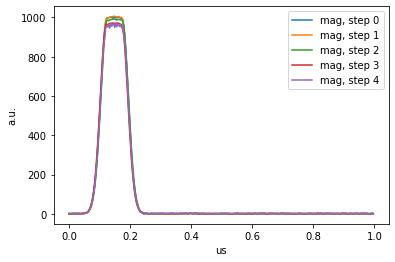

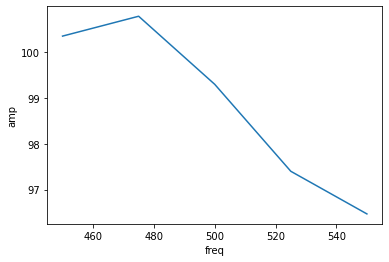

In [ ]:
GEN_CH = 0
RO_CH = 0
FREQ = 500
DELTA_FREQ = 50

# do a sweep with 5 points and plot decimated
config = {'steps': 10,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("freq_sweep", FREQ-DELTA_FREQ, FREQ+DELTA_FREQ),
          'trig_time': 0.5,
          'ro_len': 1.0,
          'flat_len': 0.05,
          'ramp_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

prog = FrequencySweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
iq_list = prog.acquire_decimated(soc, rounds=1)

plt.figure()
t = prog.get_time_axis(ro_index=0)
for ii, iq in enumerate(iq_list[0]):
    # plt.plot(t, iq[:,0], label="I value, step %d"%(ii))
    # plt.plot(t, iq[:,1], label="Q value, step %d"%(ii))
    plt.plot(t, np.abs(iq.dot([1,1j])), label="mag, step %d"%(ii))
plt.legend()
plt.ylabel("a.u.")
plt.xlabel("us")


prog = FrequencySweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
iq_list = prog.acquire(soc, rounds=1, progress=True)

plt.figure()
plt.plot(freqs, np.abs(iq_list[0][0].dot([1,1j])))
# plt.plot(np.angle(iq_list[0][0].dot([1,1j]), deg=True))
# plt.plot(iq_list[0][0,:,0], iq_list[0][0,:,1])
plt.ylabel("amp")
plt.xlabel("freq")



In [39]:
print(prog)
prog.print_pmem2hex()
prog.print_wmem2hex()
prog.print_sg_mem(sg_idx=0,gen_file=True)

macros:
	WriteReg(dst='s_core_w1', src=0)
	Delay(t=1.0, auto=True, gens=True, ros=True, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff421734c0>}, t_regs={'t': 430})
	OpenLoop(n=1, name='reps')
	OpenLoop(n=100, name='freq_sweep')
	ConfigReadout(ch=0, name='myro', t=0, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff42173e50>}, t_regs={'t': 0})
	Pulse(ch=0, name='mypulse', t=0.1, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff421737c0>}, t_regs={'t': 43})
	Trigger(ros=[0], pins=[0], t=0.4, width=0.023251488095238096, ddr4=False, mr=False, tag=None, t_params={'t': <qick.asm_v2.QickParam object at 0xffff49616b00>, 'width': <qick.asm_v2.QickParam object at 0xffff42172410>}, t_regs={'t': 172, 'width': 10}, outdict=defaultdict(<class 'int'>, {}), trigset={0, 10})
	Wait(t=0, auto=True, gens=False, ros=True, tag=None, no_warn=True, t_params={'t': <qick.asm_v2.QickParam object at 0xffff421719c0>}, t_regs={'t': 388})
	Delay(t=0.5, auto=True, gens